In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

**Load the dataset**

In [4]:
dataset_paths = {
    'categories': '../input/competitive-data-science-predict-future-sales/item_categories.csv',
    'items': '../input/competitive-data-science-predict-future-sales/items.csv',
    'sales': '../input/competitive-data-science-predict-future-sales/sales_train.csv',
    'shops': '../input/competitive-data-science-predict-future-sales/shops.csv',
    'test': '../input/competitive-data-science-predict-future-sales/test.csv'
}

In [5]:
dataset = { name: pd.read_csv(path) for name, path in dataset_paths.items()}
dataset.keys()

dict_keys(['categories', 'items', 'sales', 'shops', 'test'])

In [6]:
sales = dataset['sales']
items = dataset['items']
categories = dataset['categories']
shops = dataset['shops']
test = dataset['test']

In [7]:
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')

**Some Plots**

<AxesSubplot:xlabel='item_cnt_day'>

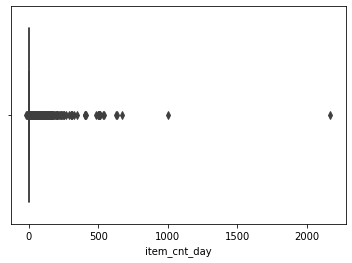

In [8]:
sns.boxplot(x=sales.item_cnt_day)

<AxesSubplot:xlabel='item_price'>

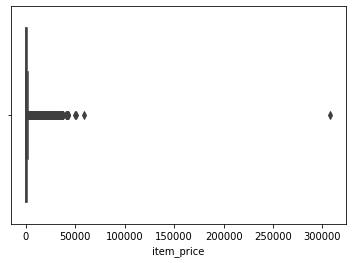

In [9]:
sns.boxplot(x=sales.item_price)

In [10]:
train = sales[(sales.item_price < 100000) & (sales.item_price > 0)]
train = train[sales.item_cnt_day < 1001]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [11]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

**Calculating the item_cnt_month**

In [12]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[sales['date_block_num']
                          == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num']
                          == block_num, 'item_id'].unique()
    df.append(
        np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns=index_cols, dtype=np.int32)

In [13]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                        .fillna(0)
                        .clip(0, 20)
                        .astype(np.float16))

**Concate the test data to train data**

In [14]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test = test.drop(columns=['ID'])
cn = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
cn.fillna(0, inplace=True)

**Feature Eng**

Item Lags

In this part i calculated lag features based on last 3 months

In [16]:
def lag_feature(data, lags, column):
    temp = data[['date_block_num', 'shop_id', 'item_id', column]]
    for lag in lags:
        shifted = temp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', column + '_lag_' + str(lag)]
        shifted['date_block_num'] += lag
        data = pd.merge(data, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        data[column+'_lag_'+str(lag)] = data[column+'_lag_'+str(lag)].astype('float16')
    return data

In [17]:
cn = lag_feature(cn, [1, 2, 3], 'item_cnt_month')

In [18]:
cn

,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,59,22154,0,1.0,NaN,NaN,NaN
1,59,2552,0,0.0,NaN,NaN,NaN
2,59,2554,0,0.0,NaN,NaN,NaN
3,59,2555,0,0.0,NaN,NaN,NaN
4,59,2564,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,1.0,0.0,0.0
11056273,45,16188,34,0.0,0.0,0.0,NaN
11056274,45,15757,34,0.0,0.0,0.0,0.0
11056275,45,19648,34,0.0,0.0,0.0,0.0


**Data leakages**

*Extracint city name*

There were the name of cities in category name col, so i created a new column with the name of city and then i calculated city coordinates based on coords ditionary

In [19]:
from sklearn.preprocessing import LabelEncoder

shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

In [20]:
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])
shops['city_cords1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_cords2'] = shops['city'].apply(lambda x: coords[x][1])

In [21]:
del coords

In [22]:
shops

,shop_name,shop_id,city,city_code,country_part,city_cords1,city_cords2
0,"!Якутск Орджоникидзе, 56 фран",0,якутск,29,4,62.028098,129.732555
1,"!Якутск ТЦ ""Центральный"" фран",1,якутск,29,4,62.028098,129.732555
2,"Адыгея ТЦ ""Мега""",2,адыгея,0,3,44.609764,40.100516
3,"Балашиха ТРК ""Октябрь-Киномир""",3,балашиха,1,1,55.809450,37.958060
4,"Волжский ТЦ ""Волга Молл""",4,волжский,2,3,53.430580,50.119000
5,"Вологда ТРЦ ""Мармелад""",5,вологда,3,2,59.223900,39.883980
6,"Воронеж (Плехановская, 13)",6,воронеж,4,3,51.672040,39.184300
7,"Воронеж ТРЦ ""Максимир""",7,воронеж,4,3,51.672040,39.184300
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,воронеж,4,3,51.672040,39.184300
9,Выездная Торговля,9,выездная,5,0,0.000000,0.000000


In [23]:
cn

,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,59,22154,0,1.0,NaN,NaN,NaN
1,59,2552,0,0.0,NaN,NaN,NaN
2,59,2554,0,0.0,NaN,NaN,NaN
3,59,2555,0,0.0,NaN,NaN,NaN
4,59,2564,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,1.0,0.0,0.0
11056273,45,16188,34,0.0,0.0,0.0,NaN
11056274,45,15757,34,0.0,0.0,0.0,0.0
11056275,45,19648,34,0.0,0.0,0.0,0.0


*in this part i merged the new information with our main dataframe(cn)*

In [24]:
cn = pd.merge(cn, shops, on=['shop_id'], how='left')

In [25]:
cn = pd.merge(cn, items, on=['item_id'], how='left')

In [26]:
cn

,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,shop_name,city,city_code,country_part,city_cords1,city_cords2,item_name,item_category_id
0,59,22154,0,1.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,1.0,0.0,0.0,"Самара ТЦ ""ПаркХаус""",самара,19,4,53.20007,50.15000,СБ. Союз 55,55
11056273,45,16188,34,0.0,0.0,0.0,NaN,"Самара ТЦ ""ПаркХаус""",самара,19,4,53.20007,50.15000,Настольная игра Нано Кёрлинг,64
11056274,45,15757,34,0.0,0.0,0.0,0.0,"Самара ТЦ ""ПаркХаус""",самара,19,4,53.20007,50.15000,НОВИКОВ АЛЕКСАНДР Новая коллекция,55
11056275,45,19648,34,0.0,0.0,0.0,0.0,"Самара ТЦ ""ПаркХаус""",самара,19,4,53.20007,50.15000,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40


Here, I deleted some dataframe becuase of memory restrioctions

In [27]:
del shops
del items
del categories
del sales
del test

**Working on date**

In [28]:
from calendar import monthrange
from calendar import monthcalendar

calculate year and month based on date_num_block

In [29]:
def to_year_and_month(date_block_num, base_year = 2013):
    year = base_year + date_block_num // 12
    month = 1 + date_block_num % 12
    return year, month

calculate number of weekends and the length of month 

In [30]:
def count_weekends(year, month):
    count = 0
    for week in monthcalendar(year, month):
        if week[6] != 0:
            count += 1
    return count


def to_apply_wc(x):
    return count_weekends(x[0], x[1])

In [31]:
def count_days(x):
    return monthrange(x[0], x[1])[1]

> year and month

In [32]:
# calculate year and month for every date_block_num in our dataset!
year_month = {i: to_year_and_month(i) for i in range(35)}
cn['year'] = cn['date_block_num'].apply(lambda x: year_month[x][0])
cn['month'] = cn['date_block_num'].apply(lambda x: year_month[x][1])

> number of days in every month

In [33]:
cn['number_of_days'] = cn[['year', 'month']].apply(count_days, axis=1)

> number of weekends in every month

In [34]:
cn['number_of_weekends'] = cn[['year', 'month']].apply(to_apply_wc, axis=1)

In [35]:
cn

,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,shop_name,city,city_code,country_part,city_cords1,city_cords2,item_name,item_category_id,year,month,number_of_days,number_of_weekends
0,59,22154,0,1.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,ЯВЛЕНИЕ 2012 (BD),37,2013,1,31,4
1,59,2552,0,0.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,DEEP PURPLE The House Of Blue Light LP,58,2013,1,31,4
2,59,2554,0,0.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,DEEP PURPLE Who Do You Think We Are LP,58,2013,1,31,4
3,59,2555,0,0.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2013,1,31,4
4,59,2564,0,0.0,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",ярославль,30,2,57.62987,39.87368,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,2013,1,31,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,1.0,0.0,0.0,"Самара ТЦ ""ПаркХаус""",самара,19,4,53.20007,50.15000,СБ. Союз 55,55,2015,11,30,5
11056273,45,16188,34,0.0,0.0,0.0,NaN,"Самара ТЦ ""ПаркХаус""",самара,19,4,53.20007,50.15000,Настольная игра Нано Кёрлинг,64,2015,11,30,5
11056274,45,15757,34,0.0,0.0,0.0,0.0,"Самара ТЦ ""ПаркХаус""",самара,19,4,53.20007,50.15000,НОВИКОВ АЛЕКСАНДР Новая коллекция,55,2015,11,30,5
11056275,45,19648,34,0.0,0.0,0.0,0.0,"Самара ТЦ ""ПаркХаус""",самара,19,4,53.20007,50.15000,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,2015,11,30,5


in this call i deleted some columns because they were not helpful and memory restriction.

In [36]:
del cn['shop_name']
del cn['city']
del cn['item_name']
del cn['year']
del cn['month']

In [37]:
cn

,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code,country_part,city_cords1,city_cords2,item_category_id,number_of_days,number_of_weekends
0,59,22154,0,1.0,NaN,NaN,NaN,30,2,57.62987,39.87368,37,31,4
1,59,2552,0,0.0,NaN,NaN,NaN,30,2,57.62987,39.87368,58,31,4
2,59,2554,0,0.0,NaN,NaN,NaN,30,2,57.62987,39.87368,58,31,4
3,59,2555,0,0.0,NaN,NaN,NaN,30,2,57.62987,39.87368,56,31,4
4,59,2564,0,0.0,NaN,NaN,NaN,30,2,57.62987,39.87368,59,31,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,1.0,0.0,0.0,19,4,53.20007,50.15000,55,30,5
11056273,45,16188,34,0.0,0.0,0.0,NaN,19,4,53.20007,50.15000,64,30,5
11056274,45,15757,34,0.0,0.0,0.0,0.0,19,4,53.20007,50.15000,55,30,5
11056275,45,19648,34,0.0,0.0,0.0,0.0,19,4,53.20007,50.15000,40,30,5


number of days in months which shop are open

In [38]:
cn['buisness_days'] = cn['number_of_days'] - cn['number_of_weekends']

In [39]:
del cn['number_of_days']
del cn['number_of_weekends']

In [40]:
cn

,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code,country_part,city_cords1,city_cords2,item_category_id,buisness_days
0,59,22154,0,1.0,NaN,NaN,NaN,30,2,57.62987,39.87368,37,27
1,59,2552,0,0.0,NaN,NaN,NaN,30,2,57.62987,39.87368,58,27
2,59,2554,0,0.0,NaN,NaN,NaN,30,2,57.62987,39.87368,58,27
3,59,2555,0,0.0,NaN,NaN,NaN,30,2,57.62987,39.87368,56,27
4,59,2564,0,0.0,NaN,NaN,NaN,30,2,57.62987,39.87368,59,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,1.0,0.0,0.0,19,4,53.20007,50.15000,55,25
11056273,45,16188,34,0.0,0.0,0.0,NaN,19,4,53.20007,50.15000,64,25
11056274,45,15757,34,0.0,0.0,0.0,0.0,19,4,53.20007,50.15000,55,25
11056275,45,19648,34,0.0,0.0,0.0,0.0,19,4,53.20007,50.15000,40,25


in this part i created some mean encoded features

In [41]:
item_id_target_mean = cn.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
cn = pd.merge(cn, item_id_target_mean, on=['date_block_num','item_id'], how='left')

cn['item_target_enc'] = (cn['item_target_enc'].astype(np.float16))

cn = lag_feature(cn, [1, 2, 3], 'item_target_enc')
cn.drop(['item_target_enc'], axis=1, inplace=True)

del item_id_target_mean

In [42]:
item_id_target_mean = cn.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
cn = pd.merge(cn, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

cn['item_loc_target_enc'] = (cn['item_loc_target_enc'].astype(np.float16))

cn = lag_feature(cn, [1, 2, 3], 'item_loc_target_enc')
cn.drop(['item_loc_target_enc'], axis=1, inplace=True)

del item_id_target_mean

In [43]:
item_id_target_mean = cn.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

cn = pd.merge(cn, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

cn['item_shop_target_enc'] = (cn['item_shop_target_enc'].astype(np.float16))

cn = lag_feature(cn, [1, 2, 3], 'item_shop_target_enc')
cn.drop(['item_shop_target_enc'], axis=1, inplace=True)

del item_id_target_mean

In [44]:
first_item_block = cn.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = cn[cn['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [45]:
cn = pd.merge(cn, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
cn = pd.merge(cn, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

In [46]:
del first_item_block
del first_shop_item_buy_block

In [47]:
cn = cn.fillna(0)

In [48]:
cn

,shop_id,item_id,date_block_num,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code,country_part,city_cords1,...,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,item_first_interaction,first_date_block_num
0,59,22154,0,1.0,0.0,0.0,0.0,30,2,57.62987,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,59,2552,0,0.0,0.0,0.0,0.0,30,2,57.62987,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2,59,2554,0,0.0,0.0,0.0,0.0,30,2,57.62987,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,59,2555,0,0.0,0.0,0.0,0.0,30,2,57.62987,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,59,2564,0,0.0,0.0,0.0,0.0,30,2,57.62987,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,1.0,0.0,0.0,19,4,53.20007,...,0.023254,0.071411,0.5,0.0,0.0,1.0,0.0,0.0,0.0,23.0
11056273,45,16188,34,0.0,0.0,0.0,0.0,19,4,53.20007,...,0.069763,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0
11056274,45,15757,34,0.0,0.0,0.0,0.0,19,4,53.20007,...,0.069763,0.095215,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0
11056275,45,19648,34,0.0,0.0,0.0,0.0,19,4,53.20007,...,0.069763,0.166626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0


In [49]:
X_train = cn[cn.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = cn[cn.date_block_num < 33]['item_cnt_month']
X_valid = cn[cn.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = cn[cn.date_block_num == 33]['item_cnt_month']
X_test = cn[cn.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del cn

**LightGBM**

In [50]:
import lightgbm as lgb

In [ ]:
# list of features which are used in models
feature_name = X_train.columns.tolist()

feature_name

Here, I wrote a some cells for lightGBM model and i tried this model with deffrent hyperparameters. At the end i selected this hyperparameters.

In [52]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 255,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1,
    'force_row_wise' : True
}

In [53]:
feature_name_indexes = [ 
                        'country_part', 
                        'item_category_id',
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

In [54]:
evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round = 4000,
        valid_sets = (lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval = 100, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 10603905, number of used features: 23


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.301121
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.04395	valid_1's rmse: 1.00269
[200]	training's rmse: 0.954928	valid_1's rmse: 0.945561
[300]	training's rmse: 0.910353	valid_1's rmse: 0.922787
[400]	training's rmse: 0.885673	valid_1's rmse: 0.913656
[500]	training's rmse: 0.868897	valid_1's rmse: 0.91065
[600]	training's rmse: 0.856357	valid_1's rmse: 0.909224
[700]	training's rmse: 0.845013	valid_1's rmse: 0.909976
Early stopping, best iteration is:
[630]	training's rmse: 0.853075	valid_1's rmse: 0.908781


In [55]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('gbm_submission.csv', index=False)

**Linear Regression**

Simple Linear Regression using sklearn

In [56]:
X_train = X_train.fillna(0)

In [57]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train.values, Y_train)

LinearRegression()

In [58]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
pred_lr = lr.predict(X_test[feature_name].values)

lr_submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": pred_lr
})
lr_submission.to_csv('lr_submission.csv', index=False)

A catboost model

In [59]:
from catboost import CatBoostRegressor

In [63]:
cat_features = ['country_part', 
                'item_category_id', 
                'city_code']

catboost = CatBoostRegressor(random_state=1, 
                             iterations=2000, verbose=200, depth = 4, 
                             learning_rate=0.01, l2_leaf_reg=7,
                             max_leaves = 2047, min_data_in_leaf = 1,
                             subsample = 0.7,
                             loss_function='RMSE', eval_metric='RMSE',
                             task_type='GPU',early_stopping_rounds=30,
                             grow_policy='Lossguide', bootstrap_type='Poisson',
                            cat_features=cat_features)

In [65]:
catboost.fit(X_train, Y_train.astype(float))

0:	learn: 1.2240723	total: 56.3ms	remaining: 1m 52s
200:	learn: 0.9688332	total: 11.2s	remaining: 1m 40s
400:	learn: 0.9462244	total: 22.1s	remaining: 1m 28s
600:	learn: 0.9371604	total: 32.9s	remaining: 1m 16s
800:	learn: 0.9311432	total: 44.1s	remaining: 1m 6s
1000:	learn: 0.9262544	total: 54.5s	remaining: 54.4s
1200:	learn: 0.9227041	total: 1m 4s	remaining: 43.1s
1400:	learn: 0.9197799	total: 1m 15s	remaining: 32.1s
1600:	learn: 0.9173398	total: 1m 26s	remaining: 21.4s
1800:	learn: 0.9152135	total: 1m 36s	remaining: 10.6s
1999:	learn: 0.9133025	total: 1m 46s	remaining: 0us


In [67]:
predict_cb_valid = catboost.predict(X_valid)
predict_cb_test = catboost.predict(X_test)

In [80]:
submission_c = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": predict_cb_test
})
submission_c.to_csv('cat_submission.csv', index=False)

Random Forest model

In [68]:
rf = RandomForestRegressor(random_state = 1, max_depth=10, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=11, n_estimators=75)

In [71]:
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=11, n_estimators=75, random_state=1)

In [ ]:
pickle.dump(rf, open('rf.sav', 'wb'))

In [72]:
predict_rf_valid = rf.predict(X_valid)
predict_rf_test = rf.predict(X_test)

In [81]:
submission_rf = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": predict_rf_test
})
submission_rf.to_csv('rf_submission.csv', index=False)

**Ensembling**

In This part of the notebook, I created data frames based on the predictions of models on validation and test data, then I wrote a cell for a simple lineare regression as 2nd level model.

In [73]:
lr_val_pred = lr.predict(X_valid[feature_name].values)
gbm_val_pred = gbm.predict(X_valid[feature_name])


lr_test_pred = lr.predict(X_test[feature_name].values)

gbm_test_pred = gbm.predict(X_test[feature_name])

In [76]:
ens_train = pd.DataFrame({
    "lr": lr_val_pred,
    "gbm": gbm_val_pred,
    "rf": predict_rf_valid,
    "cb": predict_cb_valid
    
})

ens_test = pd.DataFrame({
    "lr": lr_test_pred,
    "gbm": gbm_test_pred,
    "rf": predict_rf_test,
    "cb": predict_cb_test
})

In [77]:
final = LinearRegression()
final.fit(ens_train.values, Y_valid)

LinearRegression()

In [78]:
f_p = final.predict(ens_test.values)

In [79]:
ens_test = pd.DataFrame({
    "item_cnt_month": f_p
})
ens_test.to_csv('ens_test_submission.csv')